In [5]:
import rasterio
import matplotlib.pyplot as plt

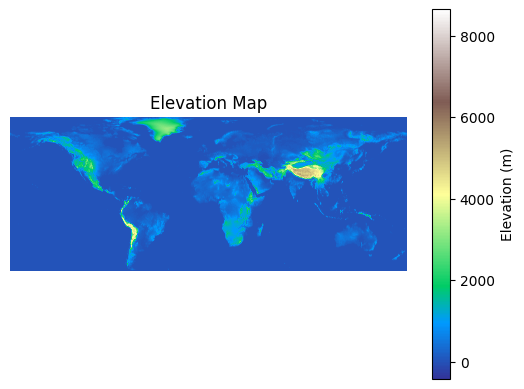

In [ ]:
filepath = "data\elevation_1KMmd_GMTEDmd.tif"
# Load the GeoTIFF
with rasterio.open(filepath) as src:
    elevation = src.read(1)  # First band
    profile = src.profile    # Metadata like CRS, transform

# Plot elevation terrain
plt.imshow(elevation, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title('Elevation Map')
plt.axis('off')
plt.show()

In [13]:
print(src.crs)

EPSG:4326


In [14]:
print(src.transform)

| 0.01, 0.00,-180.00|
| 0.00,-0.01, 84.00|
| 0.00, 0.00, 1.00|


In [15]:
print(src.bounds)

BoundingBox(left=-180.0, bottom=-56.0, right=180.0, top=84.0)


In [ ]:
from rasterio.transform import rowcol
import pyproj
from pyproj import Transformer

lon, lat = -87.638018, 41.963379  # Example: Fremont, CA

# Open the GeoTIFF
with rasterio.open(filepath) as src:
    # Transform geographic coordinates to the raster's CRS
    transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
    x, y = transformer.transform(lon, lat)

    # Convert to row/col indices
    row, col = rowcol(src.transform, x, y)

    # Read the elevation value
    elevation = src.read(1)[row, col]

print(f"Elevation at ({lat}, {lon}) is {elevation} meters")

Elevation at (41.963379, -87.638018) is 175.5 meters


# Generating updated data with Elevation(m)

In [ ]:
ebd_filepath = "../data/training_data/ebd_2025-08-20-20-40-54_34.05_-118.24_30_50.csv"
df = pd.read_csv(ebd_filepath)

with rasterio.open(filepath) as src:
    transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)

    # Transform all coordinates at once
    coords = list(zip(df['lng'], df['lat']))
    transformed = transformer.transform(*zip(*coords))  # (x_list, y_list)

    # Convert to row/col indices
    rows, cols = zip(*[rowcol(src.transform, x, y) for x, y in zip(*transformed)])

    # Read elevation values in bulk
    band = src.read(1)
    elevations = [band[row, col] if 0 <= row < band.shape[0] and 0 <= col < band.shape[1] else None
                  for row, col in zip(rows, cols)]

df['elevation_meters'] = elevations

In [44]:
updated_file_name = "data/updated_ebd_2025-08-20-20-40-54_34.05_-118.24_30_50.csv"
df.to_csv(updated_file_name)